# **Spelling Correction**

## Configuration


You can download the data:
```python
!!curl -O http://www.manythings.org/anki/fra-eng.zip
!!unzip fra-eng.zip
```


*I train this model on my personal laptop and this is my GPU versions.*

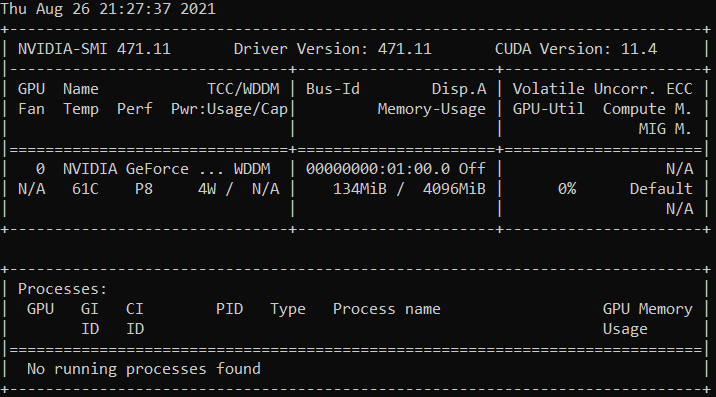

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [ ]:
num_samples = 30000
data_path = "fra.txt"

## Load & Clean Data


In [ ]:
# Vectorize the data.
input_extract = []
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
    for line in lines[80000:min(80000+num_samples, len(lines)-1)]:
        input_text, translated_text, _ = line.split("\t")
        input_extract.append(input_text)

In [ ]:
import re

def clean_characters(data):
    data = re.sub(r"[^0-9a-zA-Z' -]+","", data)
    return data

input_texts = []
for input in input_extract:
    input_texts.append(clean_characters(input))

In [ ]:
def extract_character(data):
    special_words = ["\t","\n"]
    set_words = set([character for line in data for character in line])
    int_to_vocab = {word_i: word for word_i, word in enumerate(special_words + list(set_words))}
    vocab_to_int = {word: word_i for word_i, word in int_to_vocab.items()}
    return int_to_vocab, vocab_to_int

int_to_vocab, vocab_to_int = extract_character(input_texts)

print(f'The vocabulary contains {len(vocab_to_int)} characters.')
print(sorted(vocab_to_int))

The vocabulary contains 66 characters.
['\t', '\n', ' ', "'", '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:
input_texts[29990:30000]

['What do you think of this hat',
 'What do you think of this hat',
 'What do you think of this tie',
 'What do you think of this tie',
 'What do you want me to do now',
 'What do you want me to do now',
 'What exactly are you implying',
 'What exactly are you implying',
 'What exactly is going on here',
 'What goes around comes around']

In [ ]:
characters = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',]

def make_misspellings(sentence, threshold):
    misspellings = ''
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0,1,1)
        if random < threshold:
            misspellings += sentence[i]
        else:
            new_random = np.random.uniform(0,1,1)
            # 50% chance characters will swap locations
            if new_random >= 0.5:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    misspellings += sentence[i]
                else:
                    # if any other character, swap order with following character
                    misspellings += sentence[i+1]
                    misspellings += sentence[i]
                    i += 1
            # 50% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.5:
                random_letter = np.random.choice(characters, 1)[0]
                misspellings += random_letter

        i += 1

    return misspellings

def generate_train_data(input_texts, threshold):
    train_inputs = []
    for input in input_texts:
        b = make_misspellings(input, threshold)
        train_inputs.append(b)
    return train_inputs

def generate_encoder_input(inputs):
    max_encoder_length = max([len(text) for text in inputs])
    encoder_input_data = np.zeros((num_samples,max_encoder_length,num_encoder_tokens),dtype="float32")
    for i,input in enumerate(inputs):
        for j,char in enumerate(input):
            encoder_input_data[i, j, vocab_to_int[char]] = 1.0
        encoder_input_data[i, j+1:, vocab_to_int[' ']] = 1.0
    return encoder_input_data

In [ ]:
test_inputs = []
threshold = 0.95

for input in input_texts:
    a = "\t" + input + "\n"
    test_inputs.append(a)

train_inputs = generate_train_data(input_texts, threshold)

In [ ]:
len(train_inputs)

30000

In [ ]:
for i in range(29000,29010):
    print(train_inputs[i])
    print(test_inputs[i][1:])
    print()

Thye'ret he cream of the crop
They're the cream of the crop


They're the cream of the crod
They're the cream of the crop


They're walqinu without shoes
They're walking without shoes


Things ore not what they seem
Things are not what they seem


Thinsgsare ont what they seem
Things are not what they seem


Thirteen percent were opposed
Thirteen percent were opposed


This applk has started to rot
This apple has started to rot


This biogwaphy is fascinating
This biography is fascinating


This book is full of pistawes
This book is full of mistakes


This book is'nt worti reading
This book isn't worth reading




In [ ]:
num_encoder_tokens = len(vocab_to_int)
num_decoder_tokens = len(vocab_to_int)
max_encoder_length = max([len(text) for text in train_inputs])
max_decoder_length = max([len(text) for text in test_inputs])

print("Number of samples:", num_samples)
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_length)
print("Max sequence length for outputs:", max_decoder_length)

Number of samples: 30000
Number of unique input tokens: 66
Number of unique output tokens: 66
Max sequence length for inputs: 29
Max sequence length for outputs: 31


In [ ]:
encoder_input_data = generate_encoder_input(train_inputs)

decoder_input_data = np.zeros(
    (num_samples, max_decoder_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (num_samples, max_decoder_length, num_decoder_tokens), dtype="float32"
)

for i, test_input in enumerate(test_inputs):
    for t, char in enumerate(test_input):
        decoder_input_data[i, t, vocab_to_int[char]] = 1.0
        if t > 0:
            decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.0
    decoder_input_data[i, t + 1 :, vocab_to_int[" "]] = 1.0
    decoder_target_data[i, t:, vocab_to_int[" "]] = 1.0

In [ ]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_target_data.shape)

(30000, 29, 66)
(30000, 31, 66)
(30000, 31, 66)


## Model


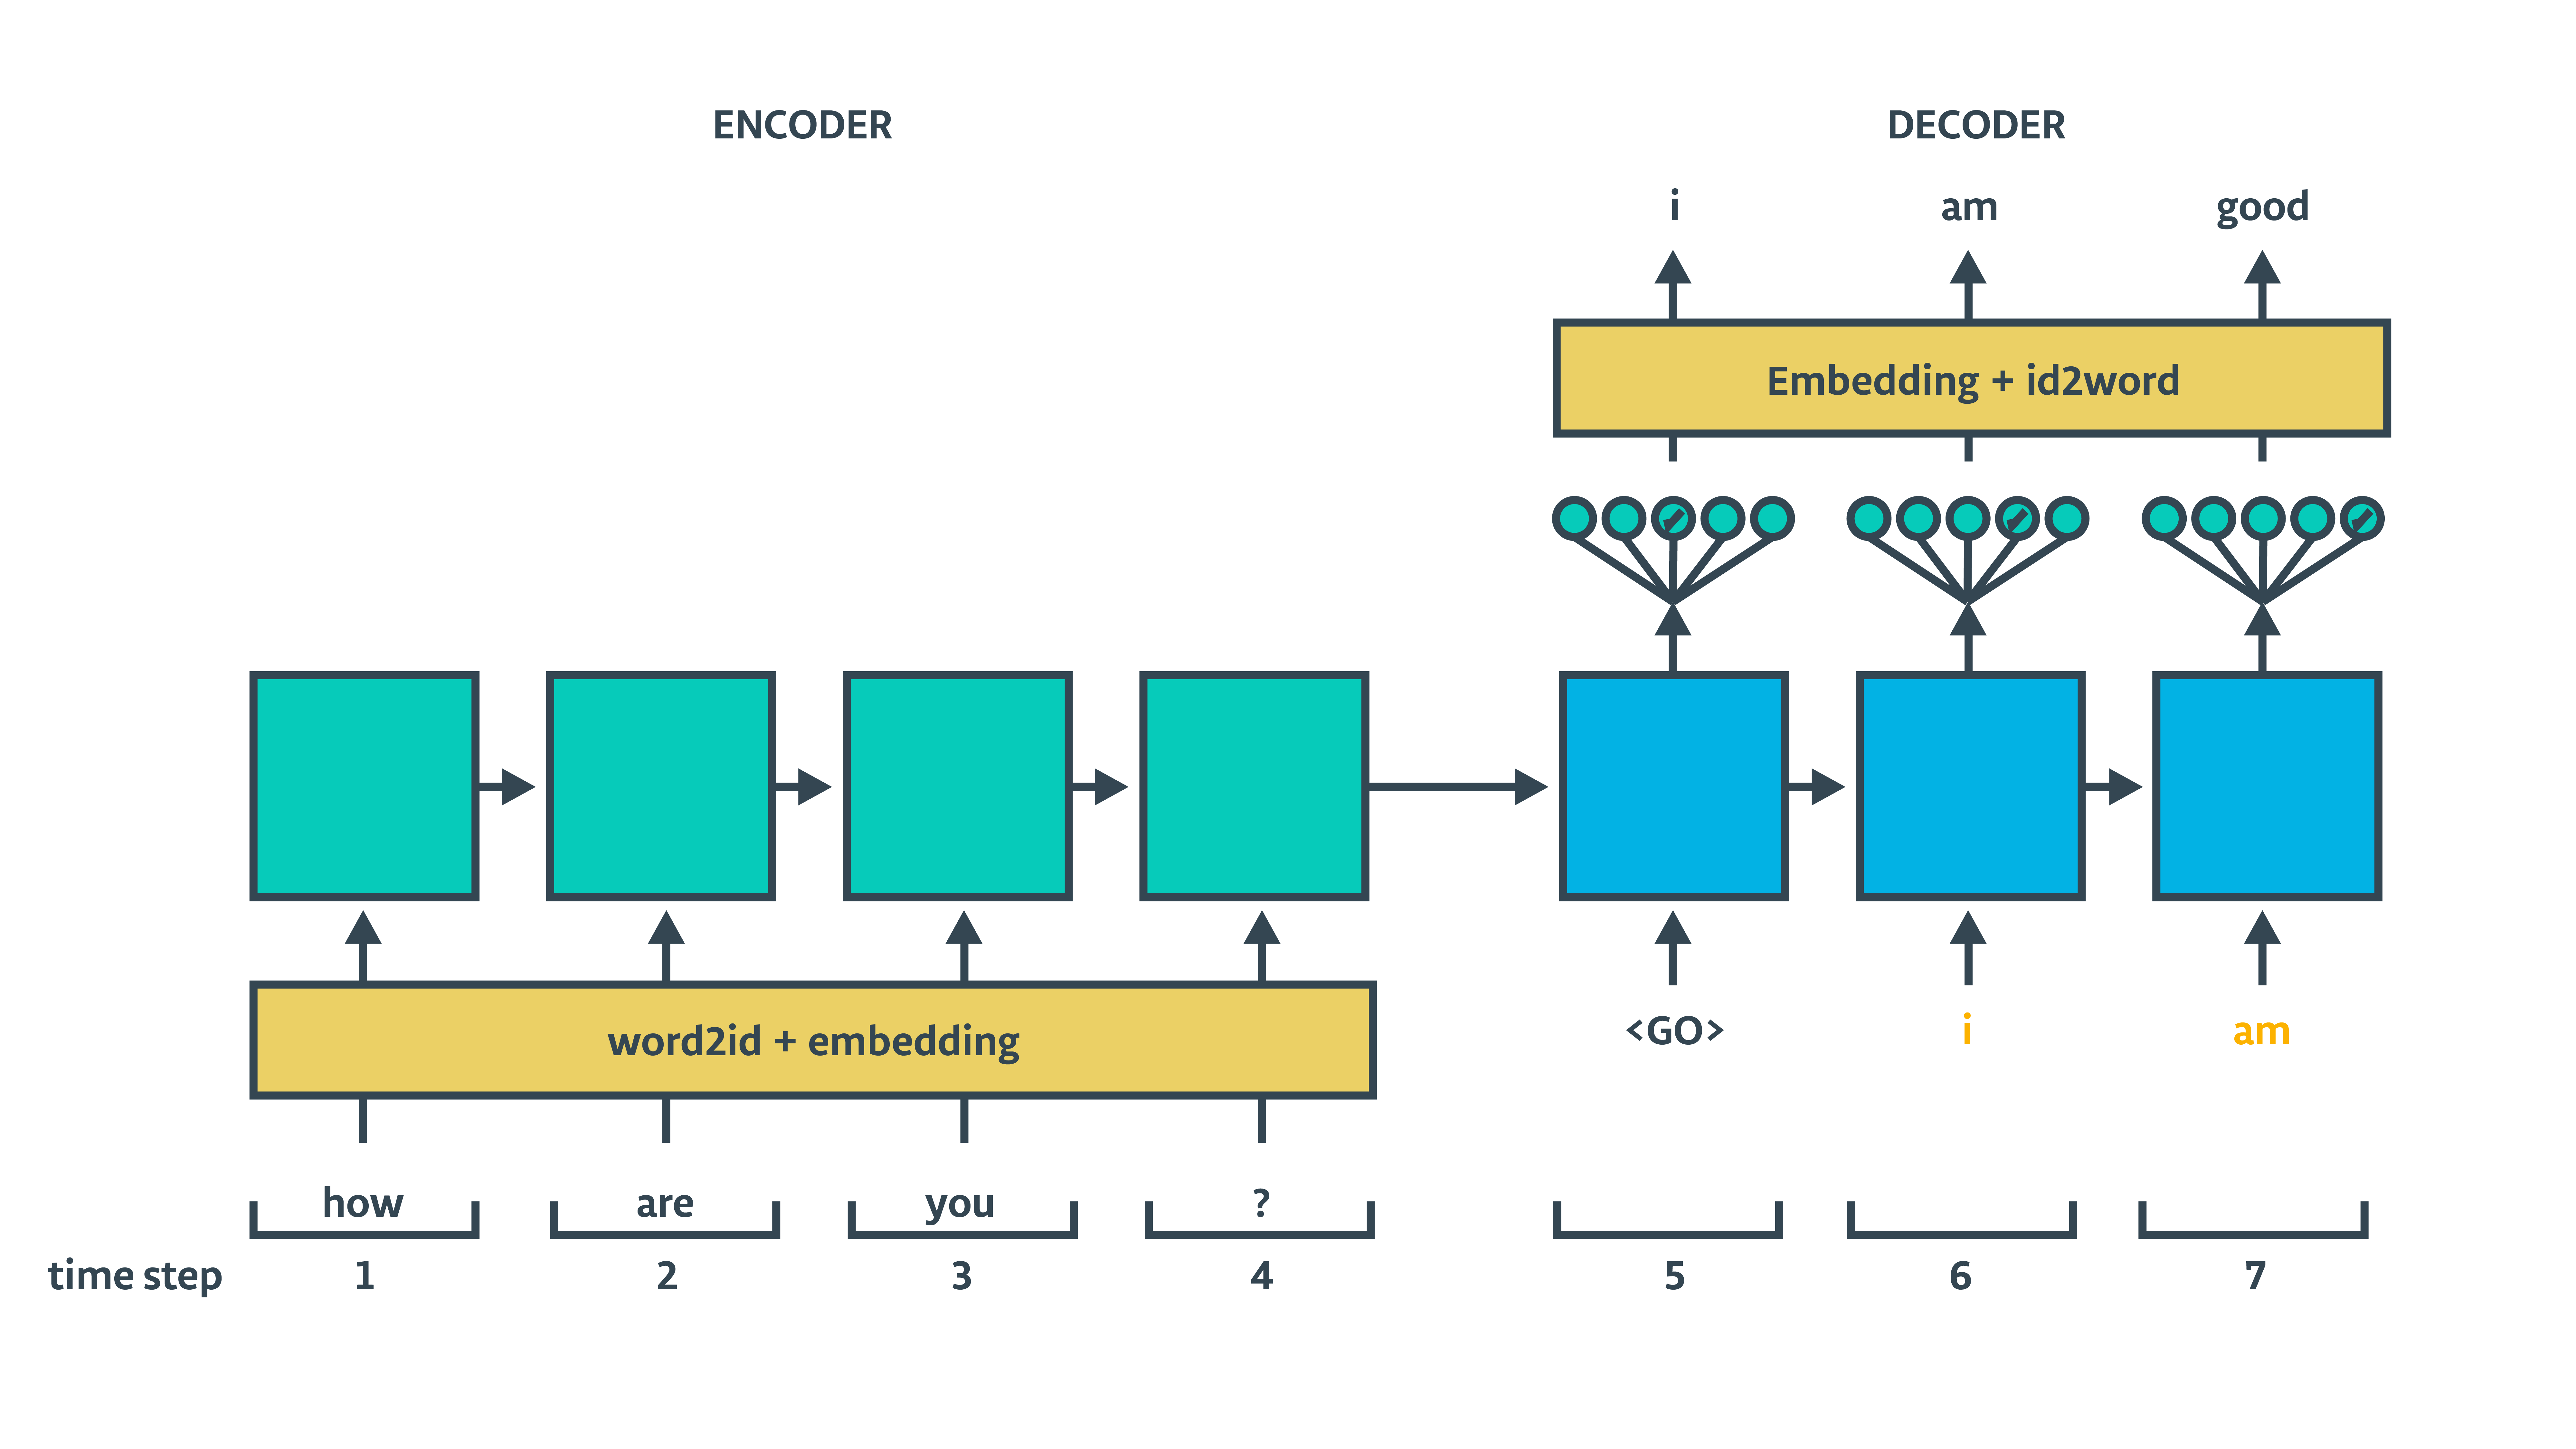

Before I came up with this model, I tried a lot of settings. Finally, I figured out these settings work best!

In [ ]:
batch_size = 64
epochs = 50
latent_dim = 512
threshold = 0.95


In [ ]:
# Encoder
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.Bidirectional(keras.layers.LSTM(latent_dim, return_state=True, dropout=0.2))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)

# state_h: the last hidden state
# state_c: the last cell state
state_h = keras.layers.Concatenate()([forward_h, backward_h])
state_c = keras.layers.Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))
decoder_lstm = keras.layers.LSTM(2*latent_dim, return_sequences=True, return_state=True, dropout=0.1)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, None, 66)]   0                                            
__________________________________________________________________________________________________
bidirectional_8 (Bidirectional) [(None, 1024), (None 2371584     input_21[0][0]                   
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, None, 66)]   0                                            
__________________________________________________________________________________________________
concatenate_13 (Concatenate)    (None, 1024)         0           bidirectional_8[0][1]            
                                                                 bidirectional_8[0][3]     

## Training


In [ ]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

h_loss = []
h_val_loss = []

for i in range(epochs):
    print(f'Epoch {i+1}/{epochs}')
    train_inputs = generate_train_data(input_texts,threshold)
    encoder_input_data = generate_encoder_input(train_inputs)
    print('Generate new data.')
    h = model.fit(
        [encoder_input_data, decoder_input_data],
        decoder_target_data,
        batch_size=batch_size,
        epochs=1,
        validation_split=0.2,
#         callbacks=callbacks,
    )
    h_loss.append(h.history['loss'])
    h_val_loss.append(h.history['val_loss'])


Epoch 1/50
Generate new data.
375/375 [==============================] - 32s 73ms/step - loss: 2.0941 - accuracy: 0.4160 - val_loss: 1.5886 - val_accuracy: 0.5312
Epoch 2/50
Generate new data.
375/375 [==============================] - 26s 70ms/step - loss: 1.1828 - accuracy: 0.6532 - val_loss: 0.9556 - val_accuracy: 0.7162
Epoch 3/50
Generate new data.
375/375 [==============================] - 26s 70ms/step - loss: 0.8156 - accuracy: 0.7613 - val_loss: 0.6693 - val_accuracy: 0.8001
Epoch 4/50
Generate new data.
375/375 [==============================] - 26s 70ms/step - loss: 0.6161 - accuracy: 0.8206 - val_loss: 0.4937 - val_accuracy: 0.8557
Epoch 5/50
Generate new data.
375/375 [==============================] - 26s 71ms/step - loss: 0.4957 - accuracy: 0.8570 - val_loss: 0.3976 - val_accuracy: 0.8850
Epoch 6/50
Generate new data.
375/375 [==============================] - 26s 71ms/step - loss: 0.4209 - accuracy: 0.8788 - val_loss: 0.3351 - val_accuracy: 0.9034
Epoch 7/50
Generate ne

In [ ]:
# Save model
model.save("model_1.h5")


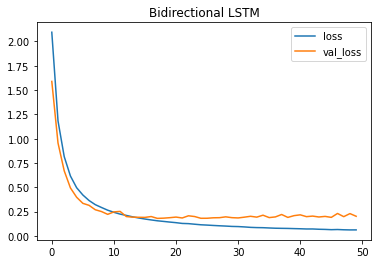

In [ ]:
import matplotlib.pyplot as plt
plt.title('Bidirectional LSTM')
plt.plot(h_loss,label="loss")
plt.plot(h_val_loss,label="val_loss")
plt.legend()
plt.show()

## Inference

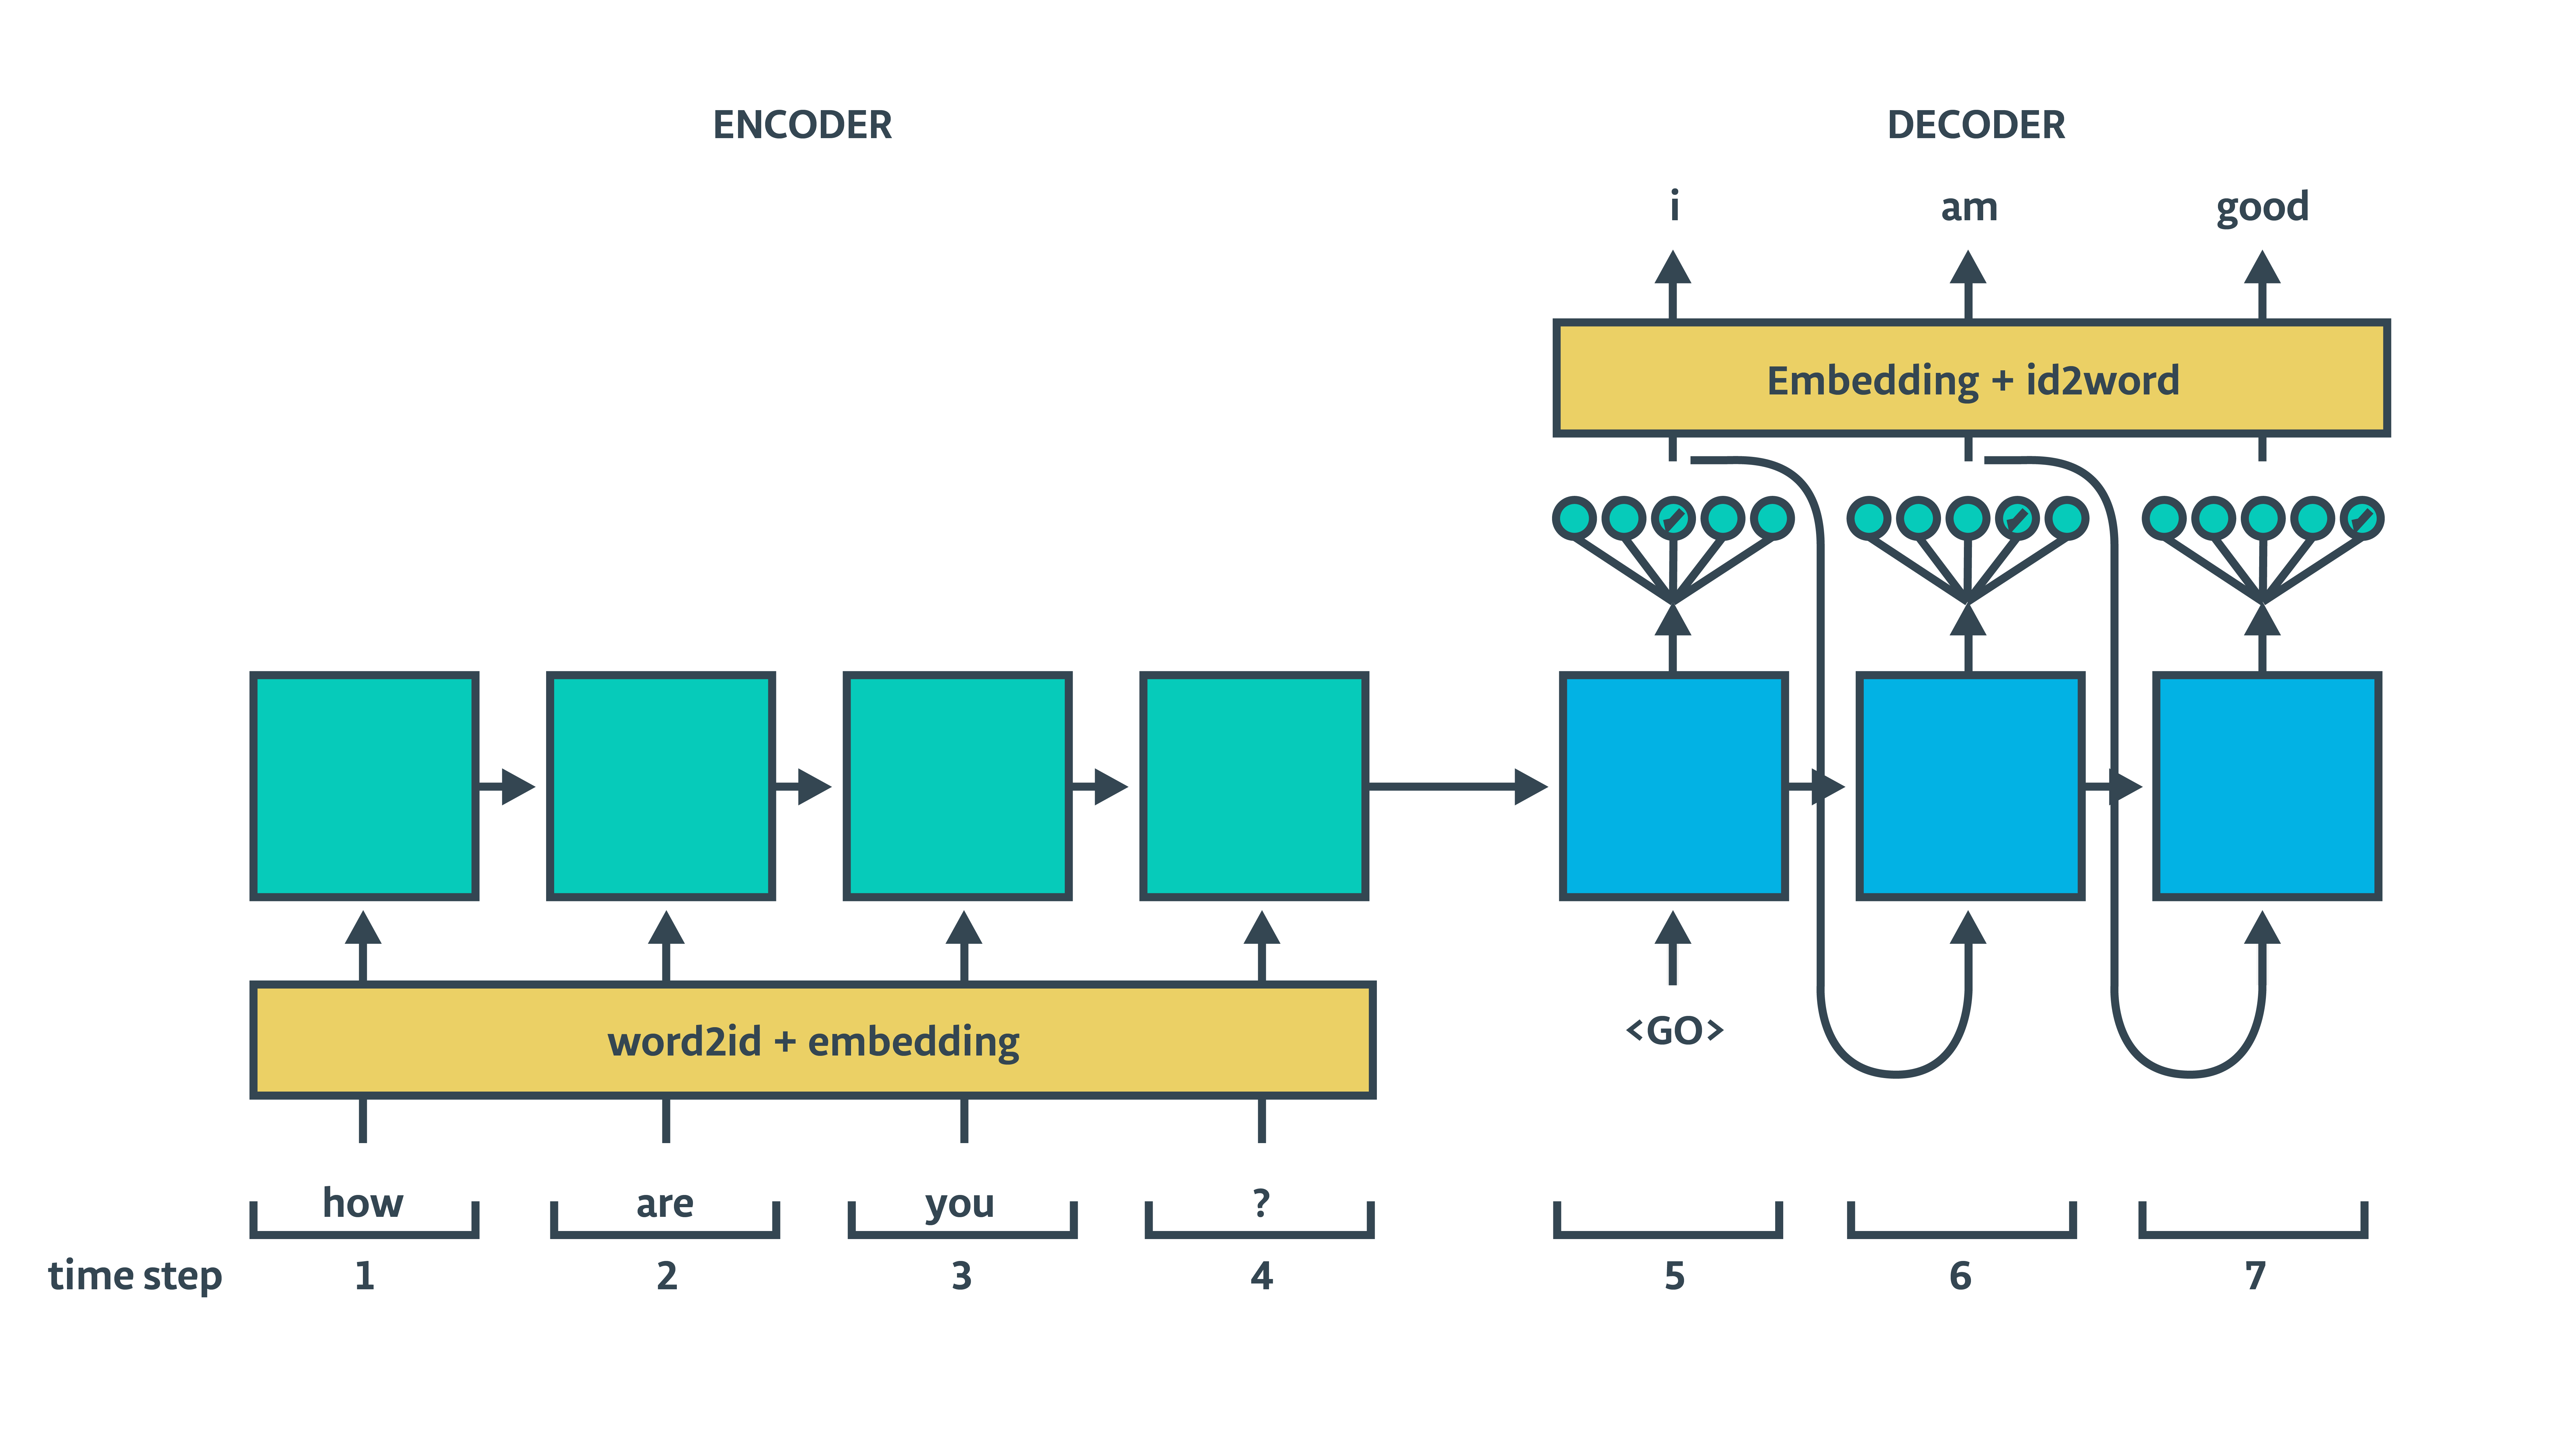

In [ ]:
# Load model
model = keras.models.load_model("model_1.h5")

encoder_inputs = model.input[0]
encoder_outputs, forward_h, forward_c, backward_h, backward_c = model.layers[1].output

state_h_enc = model.layers[3]([forward_h, backward_h])
state_c_enc = model.layers[4]([forward_c, backward_c])
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(inputs=encoder_inputs, outputs=encoder_states)

# SPLIT ENCODER AND DECODER

decoder_inputs = model.input[1]
decoder_state_input_h = keras.Input(shape=(2*latent_dim,))
decoder_state_input_c = keras.Input(shape=(2*latent_dim,))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_lstm = model.layers[5]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_state_inputs
)
decoder_state_outputs = [state_h_dec, state_c_dec]
decoder_dense = model.layers[6]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_state_inputs,
    [decoder_outputs] + decoder_state_outputs
)

Decode Function

In [ ]:
def decode_sequence(input_text):
    encoder_states = encoder_model.predict(input_text)

    target_sentence = np.zeros((1,1,num_decoder_tokens))
    target_sentence[0,0,vocab_to_int['\t']] = 1.0

    stop_condition = False
    decoded_text = ""

    while stop_condition != True:
        output_tokens, state_h, state_c = decoder_model.predict([target_sentence] + encoder_states)

        output_position = np.argmax(output_tokens[0,-1,:])

        output_char = int_to_vocab[output_position]

        decoded_text += output_char

        if output_char == "\n" or len(decoded_text) >= max_decoder_length:
            stop_condition = True

        target_sentence = np.zeros((1,1,num_decoder_tokens))
        target_sentence[0,0,vocab_to_int[output_char]] = 1.0

        encoder_states = [state_h, state_c]

    return decoded_text

What does training dataset looks like?


In [ ]:
for i in range(10,20):
    decoded_text = decode_sequence(encoder_input_data[i:i+1])
    print(f'INPUT:\t {train_inputs[i]}')
    print(f'OUTPUT:\t {decoded_text[:-1]}')
    print(f'CORRECT: {input_texts[i]}')
    print('\n')

INPUT:	 They invited me to dinler
OUTPUT:	 They invited me to dinner
CORRECT: They invited me to dinner


INPUT:	 khey know what' sgoing on
OUTPUT:	 They know what's going on
CORRECT: They know what's going on


INPUT:	 They know wha'ts going on
OUTPUT:	 They know what's going on
CORRECT: They know what's going on


INPUT:	 They left the movie early
OUTPUT:	 They left the movie early
CORRECT: They left the movie early


INPUT:	 They left the moeie early
OUTPUT:	 They left the movie early
CORRECT: They left the movie early


INPUT:	 Theyl tve near the school
OUTPUT:	 They live near the school
CORRECT: They live near the school


INPUT:	 They looked at each other
OUTPUT:	 They looked at each other
CORRECT: They looked at each other


INPUT:	 They lcoked uptat the ksy
OUTPUT:	 They locked up at the sky
CORRECT: They looked up at the sky


INPUT:	 They made me really angry
OUTPUT:	 They made me really angry
CORRECT: They made me really angry


INPUT:	 They made us woek lal day
OUTPUT:	 The

The model works pretty well with the training dataset.

Now let's look at the randomly generated testing dataset!

In [ ]:
test_texts = generate_train_data(input_texts, 0.95)
encoder_input_data = generate_encoder_input(test_texts)

for i in range(200,210):
    decoded_text = decode_sequence(encoder_input_data[i:i+1])
    print(f'INPUT:\t {train_inputs[i]}')
    print(f'OUTPUT:\t {decoded_text[:-1]}')
    print(f'CORRECT: {input_texts[i]}')
    print('\n')

INPUT:	 This list is not ofifcial
OUTPUT:	 This list is not official
CORRECT: This list is not official


INPUT:	 This machine is wotrhless
OUTPUT:	 This machine is worthless
CORRECT: This machine is worthless


INPUT:	 This makes no sense to me
OUTPUT:	 This makes no sense to me
CORRECT: This makes no sense to me


INPUT:	 This makse no senee toeme
OUTPUT:	 This makes no sense to me
CORRECT: This makes no sense to me


INPUT:	 This man isn't my husband
OUTPUT:	 This man isn't my husband
CORRECT: This man isn't my husband


INPUT:	 This mayc hange next yeih
OUTPUT:	 This may change next year
CORRECT: This may change next year


INPUT:	 This metal is called zinq
OUTPUT:	 This matal is called zinc
CORRECT: This metal is called zinc


INPUT:	 This movie si rated PG-1g
OUTPUT:	 This movie is rated PG-13
CORRECT: This movie is rated PG-13


INPUT:	 This movie is rated PG-13
OUTPUT:	 This movie is rated PG-13
CORRECT: This movie is rated PG-13


INPUT:	 This movie makesn o sunse
OUTPUT:	 Thi

It works pretty well with the random generated data!